In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import scipy.stats as stats
import powerlaw

%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/finance_M4/my_fx_data', header = None, usecols = [1], names = ['price'])
logR = np.log(my_data).diff()
logR.drop(logR.index[0], inplace = True)

In [3]:
ripple = pd.read_csv('/home/lin/教材/Financial_data/data/Ripple.csv')
ripple['Date']=pd.to_datetime(ripple['Date'])
ripple.set_index('Date', inplace = True)
close = np.flip(ripple['Close'], 0)
logRR = np.log(close).diff()
logRR.drop(logRR.index[0], inplace = True)

In [4]:
def stationarity_tests(data, print_info=True):
    adf_p = adfuller(data)[1]
    KPSS_p = kpss(data)[1]
    
    if print_info:
        print('adfuller test')
        print(adfuller(data))
        print('KPSS test')
        print(kpss(data))
        
    return adf_p, KPSS_p


In [5]:
#%matplotlib tk
def plot_autocorrelations(data, title):
    autocorr_logR = [data.autocorr(lag=_) for _ in range(1,252)]
    autocorr_abs_logR = [abs(data).autocorr(lag=_) for _ in range(1,252)]
    autocorr_sqLogR = [(data ** 2).autocorr(lag=_) for _ in range(1,252)]
    plt.figure()
    plt.plot(range(1, 252),autocorr_logR, range(1, 252), autocorr_abs_logR, range(1, 252), autocorr_sqLogR)
    plt.title(f'Estimated autocorrelation vs lag for {title}', fontsize=20)
    plt.legend(['lot return', '|log return|', 'log return ^2'], loc = 1)
    plt.xlabel('lag', fontsize=18)
    plt.ylabel('autocorrelation', fontsize=18)
    plt.grid(True)

In [6]:
def fit_a_dist(data, distType, locAndScale=True):
    
    if locAndScale:
        loc = np.mean(data)
        scale = np.std(data)
        para = distType.fit(data, loc = loc, scale = scale)
    else:
        para = distType.fit(data)
        
    return para



In [7]:
def sep_and_mirror(data):
    posiR = data[data > 0].dropna()
    negaR = data[data < 0].dropna()
    sortedPosiR = posiR.sort_values()
    sortedNegaR = (-negaR).sort_values()

    mirrorNegative = sortedNegaR.append(-sortedNegaR)
    mirrorPosi = sortedPosiR.append(-sortedPosiR)
    return sortedPosiR, sortedNegaR, mirrorNegative, mirrorPosi


In [8]:
def get_alpha_and_start(data):
    fit = powerlaw.Fit(data)
    alpha_expo = fit.power_law.alpha
    start_x = fit.xmin
    fit.power_law.plot_ccdf
    fit.plot_ccdf
    return start_x, alpha_expo


In [9]:
def plot_alpha_fitting(data, dist_type, domain_factorf1, domain_factor2, alpha_posi, alpha_nega, adj_start1=0, adj_start2=0):
    posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(data)
    posiStart, posiAlpha = get_alpha_and_start(posiTail)
    negaStart, negaAlpha = get_alpha_and_start(negaTail)

    plt.figure()
    domain = np.linspace(max(abs(data))/1000, max(abs(data)), 1000)
    plt.loglog(posiTail, 1 - (range(1, posiTail.count() + 1))/(posiTail.count() + 1), '+b', alpha = 0.5)
    plt.loglog(negaTail, 1 - (range(1, negaTail.count() + 1))/(negaTail.count() + 1), 'xr', alpha = 0.5)
    if dist_type == stats.genpareto:
        nega_para = fit_a_dist(negaTail, dist_type, False)
        posi_para = fit_a_dist(posiTail, dist_type, False)
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=posi_para[0] , loc = posi_para[1], scale = posi_para[2]), '--b')
        plt.loglog(domain, 1 - dist_type.cdf(domain, c=nega_para[0] , loc = nega_para[1], scale = nega_para[2]), '--r')
    else:
        nega_para = fit_a_dist(mirrorNega, dist_type, False)
        posi_para = fit_a_dist(mirrorPosi, dist_type, False)
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =posi_para[0] , loc = posi_para[1], scale = posi_para[2]) - 0.5) * 2, '--b')
        plt.loglog(domain, 1 - (dist_type.cdf(domain, df =nega_para[0] , loc = nega_para[1], scale = nega_para[2]) - 0.5) * 2, '--r')


    plt.loglog(domain, (domain*domain_factorf1) ** (-alpha_posi), '-.b')
    plt.loglog(domain, (domain*domain_factor2) ** (-alpha_nega), '-.r')
    plt.loglog((posiStart+adj_start1)*np.ones(50), np.linspace(1e-4, 1.05), '--b')
    plt.loglog((negaStart+adj_start2)*np.ones(50), np.linspace(1e-4, 1.05), '--r')
    
    if dist_type == stats.genpareto:
        plt.title('compare gen_pareto fited with halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 'gen_pareto positive', 'gen_pareto negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.1])
        plt.xlim([10**(-1.2), 1.2])
    else:
        plt.title('compare t fited with mirrored halves and power law', fontsize=20)
        plt.legend(['positive data', 'negative data', 't positive', 't negative', 'power law positive', 'power law negative'])
        plt.ylim([1e-4, 1.05])
        plt.xlim([1e-2, 0.2])

    plt.xlabel('log return', fontsize=18)
    plt.ylabel('rank/cdf', fontsize=18)

In [10]:
def resample(data, days=5):
    data = np.asarray(data)
    resampled = np.zeros(int(len(data)/days))
    j = days-1
    for i in range(len(resampled)):
        resampled[i] = sum(data[j-days+1:j])
        j = j + days
    return resampled

In [11]:
def get_histo_data(data, bins):
    hist, bins = np.histogram(data, bins=bins)
    binCenters = (bins[1:] + bins[:-1]) / 2
    hist = hist/max(hist)
    
    return hist, binCenters

In [12]:
def uni_scale_with_alpha(bins, hist, days, alpha):
    binS = bins/days**(1/alpha)
    histS = hist*days**(1/alpha)/max(hist*days**(1/alpha))
    return binS, histS


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller test
(-23.262701610140457, 0.0, 6, 4189, {'1%': -3.4319120223653132, '5%': -2.8622302155703507, '10%': -2.5671374076308826}, -24993.19087817247)
KPSS test
(0.04591689237306045, 0.1, 31, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.0, 0.1)
adfuller test
(-10.924169213029211, 1.0201212291578786e-19, 11, 1606, {'1%': -3.4344283205802606, '5%': -2.8633413399051144, '10%': -2.5677289969277726}, -3606.664273929593)
KPSS test
(0.42111321712474087, 0.06805464779105998, 25, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(1.0201212291578786e-19, 0.06805464779105998)


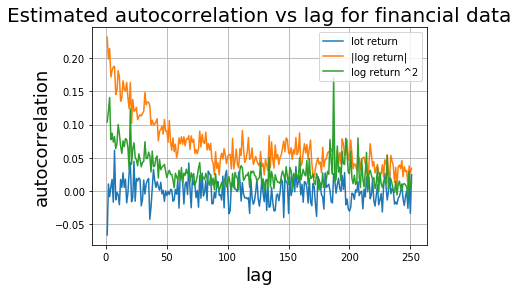

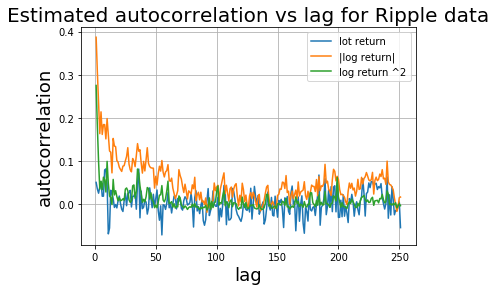

In [13]:
print(stationarity_tests(logR['price']))
print(stationarity_tests(logRR))
plot_autocorrelations(logR['price'], title='financial data')
plot_autocorrelations(logRR, title='Ripple data')

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit


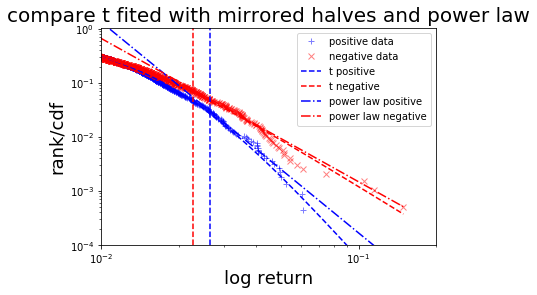

In [14]:
plot_alpha_fitting(logR['price'], stats.t, 93, 117, 3.9, 2.65, adj_start1=0.013, adj_start2=0.008)

In [15]:
#power law how to choose start point  (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3906378/)
#The methods find this start point by creating a power law fit starting from each unique value 
#in the dataset, then selecting the one that results in the minimal Kolmogorov-Smirnov distance
#between the data and the a fit. 

#When fitting alpha, it does a linear regression. The alpha it return is actually alpha+1 by our
#definition so if use, need to subtract 1

#I selected some alpha and start points myself and plotted them together with t distribution fitted with
#mirrored data. Alpha is greater than 2 which means the attractor is a nomal distribution

#Looking at these two fitting, I cannot say t distribution is constently better, but at least for the
#positive tail
#it look more like a t distribution rather than a power law decay. However, the tail we can see is just a
#sample and the real distribution is unknow. To be conservative when fitting alpha, I rather miss some
#point in the middle than miss the points at the very end of the tail


Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


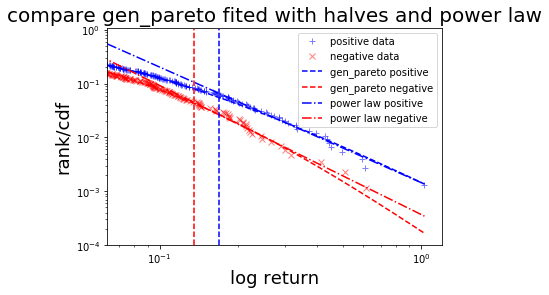

In [16]:
plot_alpha_fitting(logRR, stats.genpareto, 21, 27, 2.15, 2.4, adj_start2=0.05)

In [17]:
#same for ripple, cannot say power law fit better than the gen_pareto and alpha is higher than 2. Both 
#alpha are lower than those for financial data indicating fatter tails but still higher than 2 
#Ripple's positive tail is fatter than negative tail, this is opposite to financial data

Calculating best minimal value for power law fit
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


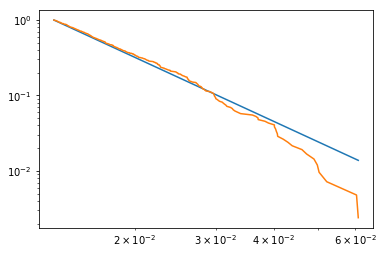

In [18]:
#This it to compare with my alpha and startpoint in the question sheet
#%matplotlib tk   
posiTail, negaTail, mirrorNega, mirrorPosi = sep_and_mirror(logR['price'])

fit = powerlaw.Fit(posiTail)
alpha_expo = fit.power_law.alpha
start_x = fit.xmin
fit.power_law.plot_ccdf()
fit.plot_ccdf()


In [19]:
weeklyF = resample(logR['price'], 5)
print(len(weeklyF))
monthlyF = resample(logR['price'], 21)
print(len(monthlyF))
weeklyR = resample(logRR, 7)
len(weeklyR)

839
199


231

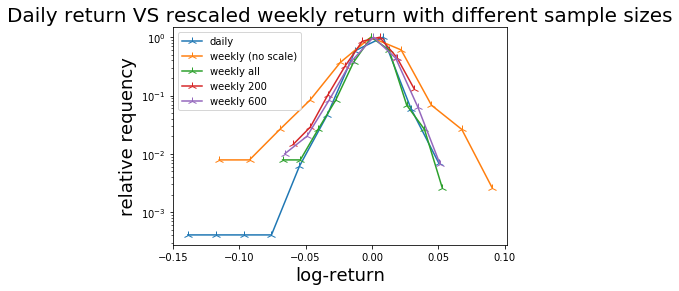

In [20]:
hist, bins = get_histo_data(logR['price'], 10)
histW1, binW1 = get_histo_data(weeklyF[:200], 8)
histW3, binW3 = get_histo_data(weeklyF[:600], 8)
histW, binW = get_histo_data(weeklyF, 10)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 3)
binW1S, histW1S = uni_scale_with_alpha(binW1, histW1, 5, 3)
binW3S, histW3S = uni_scale_with_alpha(binW3, histW3, 5, 3)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binWS, histWS, '-2', binW1S, histW1S, '-2', binW3S, histW3S, '-2', markersize=9)
plt.title('Daily return VS rescaled weekly return with different sample sizes', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly (no scale)', 'weekly all', 'weekly 200', 'weekly 600'])


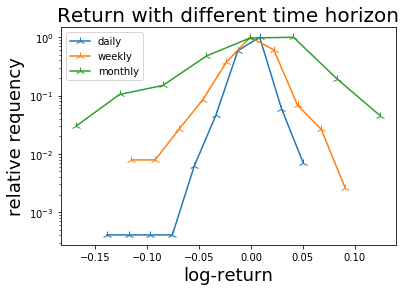

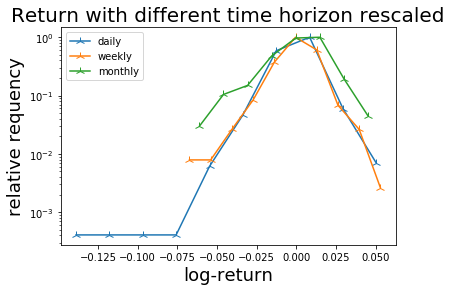

In [21]:
hist, bins = get_histo_data(logR['price'], 10)
histW, binW = get_histo_data(weeklyF, 10)
histM, binM = get_histo_data(monthlyF, 8)

binWS, histWS = uni_scale_with_alpha(binW, histW, 5, 3)
binMS, histMS = uni_scale_with_alpha(binM, histM, 21, 3)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', binM, histM, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', binMS, histMS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


In [22]:
#When using diff sample sizes, I expect that central limit is getting more and more powerful, and rescaled
#pdf will get closer and closer to daily. But this only really happens when using alpha=3 which is closer
#to the real alpha I found. But when I use alpha=2 to scale diff sample sizes, it is weirld. Which step is
#wrong? Since it has multiple steps and assumptions...
#And when scaking, useing 3 seems better with weekly which has 800+ data points, but worse for monthly,
#which has 200 points

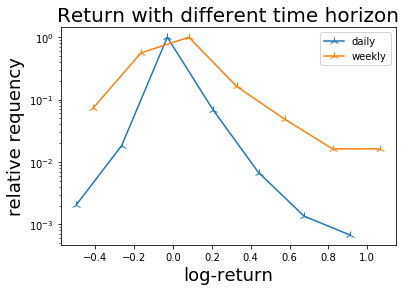

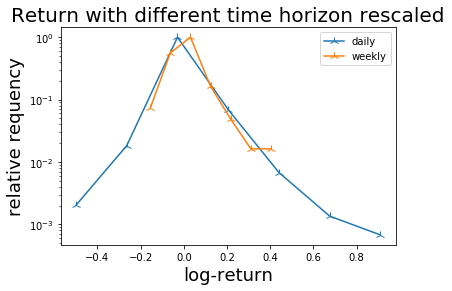

In [23]:
hist, bins = get_histo_data(logRR, 7)
histW, binW = get_histo_data(weeklyR, 7)

binWS, histWS = uni_scale_with_alpha(binW, histW, 7, 2)

plt.figure()
plt.semilogy(bins, hist, '-2', binW, histW, '-2', markersize=9)
plt.title('Return with different time horizon', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])

plt.figure()
plt.semilogy(bins, hist, '-2', binWS, histWS, '-2', markersize=9)
plt.title('Return with different time horizon rescaled', fontsize=20)
plt.xlabel('log-return', fontsize=18)
plt.ylabel('relative requency', fontsize=18)
plt.legend(['daily', 'weekly', 'monthly'])


In [24]:
#Ripple rescaled with alpha=2 doesn't look too bad since the real alpha estimated is closer to 2